In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

In [2]:
data = pd.read_csv("fer2013.csv")

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data = data.dropna()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


In [7]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [9]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [19]:
def CRNO(df, dataName):
    if dataName == "train": 
        df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence])
    else:
        df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split(' ')])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [20]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

C:\Users\User\AppData\Local\Temp\ipykernel_22848\3086980355.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


Epoch 1/50
448/448 - 29s - loss: 1.7264 - accuracy: 0.3138 - val_loss: 1.9820 - val_accuracy: 0.2151 - 29s/epoch - 64ms/step
Epoch 2/50
448/448 - 23s - loss: 1.4353 - accuracy: 0.4401 - val_loss: 1.4197 - val_accuracy: 0.4570 - 23s/epoch - 51ms/step
Epoch 3/50
448/448 - 23s - loss: 1.2730 - accuracy: 0.5095 - val_loss: 1.2902 - val_accuracy: 0.5183 - 23s/epoch - 51ms/step
Epoch 4/50
448/448 - 23s - loss: 1.1853 - accuracy: 0.5504 - val_loss: 1.3251 - val_accuracy: 0.4982 - 23s/epoch - 51ms/step
Epoch 5/50
448/448 - 23s - loss: 1.1376 - accuracy: 0.5684 - val_loss: 1.2206 - val_accuracy: 0.5456 - 23s/epoch - 51ms/step
Epoch 6/50
448/448 - 23s - loss: 1.0958 - accuracy: 0.5856 - val_loss: 1.1298 - val_accuracy: 0.5782 - 23s/epoch - 51ms/step
Epoch 7/50
448/448 - 23s - loss: 1.0621 - accuracy: 0.5965 - val_loss: 1.1407 - val_accuracy: 0.5575 - 23s/epoch - 51ms/step
Epoch 8/50
448/448 - 23s - loss: 1.0394 - accuracy: 0.6074 - val_loss: 1.0785 - val_accuracy: 0.5949 - 23s/epoch - 51ms/step


In [25]:
ferp = {'loss': [1.5080139636993408,
  1.1955863237380981,
  1.0939687490463257,
  1.0421241521835327,
  1.0058369636535645,
  0.9834072589874268,
  0.9623900055885315,
  0.9464650750160217,
  0.9354591965675354,
  0.9221512675285339,
  0.9131107330322266,
  0.9025390148162842,
  0.8969160914421082,
  0.8889154195785522,
  0.877197265625,
  0.8727055191993713,
  0.868482768535614,
  0.8611842393875122,
  0.8548768162727356,
  0.8518666625022888,
  0.8459288477897644,
  0.8427675366401672,
  0.8404917120933533,
  0.8348091244697571,
  0.8312087059020996,
  0.8244394063949585,
  0.8243153691291809,
  0.8176260590553284,
  0.8184446692466736,
  0.8119710087776184,
  0.8095816373825073,
  0.8074661493301392,
  0.8041829466819763,
  0.800312876701355,
  0.7963782548904419,
  0.7937318086624146,
  0.7932692170143127,
  0.7897855639457703,
  0.78928142786026,
  0.7842393517494202,
  0.7826583981513977,
  0.7823072075843811,
  0.779090404510498,
  0.778204083442688,
  0.7742681503295898,
  0.772610068321228,
  0.7687758803367615,
  0.7670804262161255,
  0.7685670256614685,
  0.76453697681427],
 'accuracy': [0.5011096000671387,
  0.6562401056289673,
  0.7024199366569519,
  0.729543149471283,
  0.7486350536346436,
  0.7560322880744934,
  0.7666701674461365,
  0.7791398167610168,
  0.7828736305236816,
  0.7912219762802124,
  0.7934763431549072,
  0.7989009618759155,
  0.801789402961731,
  0.805030107498169,
  0.8143295049667358,
  0.8134840726852417,
  0.8172531723976135,
  0.8188382983207703,
  0.8247208595275879,
  0.8254253268241882,
  0.8314487934112549,
  0.8321180939674377,
  0.8322589993476868,
  0.8335975408554077,
  0.835253119468689,
  0.8407129645347595,
  0.840360701084137,
  0.8422980904579163,
  0.8450456261634827,
  0.8445876836776733,
  0.847511351108551,
  0.8469125628471375,
  0.8501179814338684,
  0.854380190372467,
  0.8518440127372742,
  0.8562823534011841,
  0.8559300899505615,
  0.8599810004234314,
  0.8578322529792786,
  0.8597696423530579,
  0.8603332042694092,
  0.8627637624740601,
  0.8619183301925659,
  0.8653351664543152,
  0.8662509918212891,
  0.867343008518219,
  0.8684349656105042,
  0.8689633011817932,
  0.8665680289268494,
  0.8718518018722534],
 'val_loss': [1.7038326263427734,
  1.2753700017929077,
  1.1131142377853394,
  1.0393346548080444,
  1.0329513549804688,
  0.9785866737365723,
  0.9548394680023193,
  0.9909228682518005,
  0.9089846014976501,
  0.9655324220657349,
  0.8999008536338806,
  0.94450443983078,
  0.9004560112953186,
  0.9142440557479858,
  0.925293505191803,
  0.87059485912323,
  0.8865269422531128,
  0.8849868178367615,
  0.8664281368255615,
  0.8678487539291382,
  0.8678708076477051,
  0.8378376960754395,
  0.8778061270713806,
  0.8579590916633606,
  0.8343696594238281,
  0.8155664801597595,
  0.8385797142982483,
  0.8274936079978943,
  0.8435066342353821,
  0.8281267285346985,
  0.819995105266571,
  0.8446266055107117,
  0.8123868703842163,
  0.8070902228355408,
  0.8239073157310486,
  0.8317736387252808,
  0.8074549436569214,
  0.8093662261962891,
  0.833489716053009,
  0.8061578869819641,
  0.8125309348106384,
  0.812384843826294,
  0.8328338265419006,
  0.813995897769928,
  0.8087921738624573,
  0.8000932931900024,
  0.7927327752113342,
  0.8217427134513855,
  0.791689932346344,
  0.7945326566696167],
 'val_accuracy': [0.462144672870636,
  0.594427227973938,
  0.7036307454109192,
  0.7283985614776611,
  0.7227694988250732,
  0.7545735836029053,
  0.7711792588233948,
  0.7450042366981506,
  0.7717421650886536,
  0.7329017519950867,
  0.7872220873832703,
  0.7759639620780945,
  0.7953841686248779,
  0.779904305934906,
  0.7528848648071289,
  0.7942583560943604,
  0.7863777279853821,
  0.7984801530838013,
  0.8043906688690186,
  0.8001688718795776,
  0.7931325435638428,
  0.8229665160179138,
  0.7967914342880249,
  0.8027019500732422,
  0.8190261721611023,
  0.825218141078949,
  0.8153672814369202,
  0.8142414689064026,
  0.815930187702179,
  0.8204334378242493,
  0.8226850628852844,
  0.8156487345695496,
  0.8176189064979553,
  0.8271883130073547,
  0.8229665160179138,
  0.8162116408348083,
  0.823810875415802,
  0.8339431285858154,
  0.8150858283042908,
  0.8294399380683899,
  0.822403609752655,
  0.8280326724052429,
  0.8226850628852844,
  0.8221221566200256,
  0.8401350975036621,
  0.8367576599121094,
  0.8347874879837036,
  0.8226850628852844,
  0.8381649255752563,
  0.8412609100341797]}

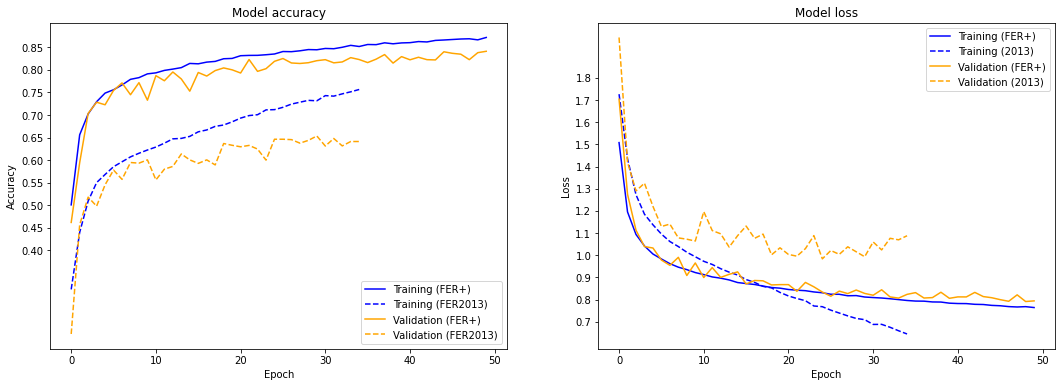

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
axes[0].plot(ferp['accuracy'], label="Training (FER+)", color="blue")
axes[0].plot(history.history['accuracy'], label="Training (FER2013)", linestyle='--', color='blue')
axes[0].plot(ferp['val_accuracy'], label="Validation (FER+)", color='orange')
axes[0].plot(history.history['val_accuracy'], label="Validation (FER2013)", linestyle='--', color='orange')
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].set_yticks(np.arange(0.4, 0.9, 0.05))
axes[1].plot(ferp['loss'], label="Training (FER+)", color="blue")
axes[1].plot(history.history['loss'], label="Training (2013)", color="blue", linestyle='--')
axes[1].plot(ferp['val_loss'], label="Validation (FER+)", color="orange")
axes[1].plot(history.history['val_loss'], label="Validation (2013)", linestyle='--', color="orange")
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yticks(np.arange(0.7, 1.9, 0.1))
plt.show()

In [24]:
results = model.evaluate(test_X, test_Y, batch_size=64)
print("test loss, test acc:", results)

57/57 [==============================] - 1s 16ms/step - loss: 0.9664 - accuracy: 0.6576
test loss, test acc: [0.9663920402526855, 0.6575647592544556]
